In [1]:
from src.reachability_analysis.simulation import get_test_label, run_scenario, get_data, get_initial_conditions
from src.clustering.run import load_config, get_cluster
from src.reachability_analysis.labeling_oracle import LABELS, LabelingOracleSINDData, LabelingOracleSVEAData, LabelingOracleROSData
from src.reachability_analysis.utils import load_data
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import pandas as pd


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/sam/Desktop/P

In [2]:
ROOT = os.getcwd()
ROOT_RESOURCES = os.getcwd() + '/resources'

In [3]:
model_file = 'ROS_experiment_2024-08-02_10-47-55_tcO' # model with aggregated_data3

index = 2
index_data = 0
folder = 'experiments'

In [4]:
config_path = '/home/sam/Desktop/Pedestrian_Project/config_ros_reduced_embedding_dim.json'

with open(config_path) as cnfg:
    config = json.load(cnfg)

In [11]:
from src.datasets.data import ROSData

config['data_dir'] = 'resources/test'
bag_reader = ROSData(config)

bag_reader.feature_df

# Assuming bag_reader.all_df is your dataframe
all_df = bag_reader.all_df

2024-08-07 14:13:53,677 | INFO : Loading 1 datasets files using 1 parallel processes ...


resources/test
[INFO]  Successfully created the data folder resources/test/reprocessed_2024-07-16-14-54-22.


In [13]:
all_df

,track_id,timestamp_ms,x,y,vx,vy,ax,ay,chunk_idx,unique_int_id
data_chunk_len,,,,,,,,,,
0,reprocessed_2024-07-16-14-54-22.bag_772,0.000000,-1019.638721,76.279057,0.000000,0.000000,0.0,0.0,0,0
0,reprocessed_2024-07-16-14-54-22.bag_772,0.000000,-1019.638721,76.279057,0.000000,0.000000,0.0,0.0,0,0
0,reprocessed_2024-07-16-14-54-22.bag_772,66.639160,-1019.708111,76.237210,0.000000,0.000000,0.0,0.0,0,0
0,reprocessed_2024-07-16-14-54-22.bag_772,66.639160,-1019.708111,76.237210,0.000000,0.000000,0.0,0.0,0,0
0,reprocessed_2024-07-16-14-54-22.bag_772,133.132080,-1019.773291,76.194921,0.000000,0.000000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
424,reprocessed_2024-07-16-14-54-22.bag_1030,232976.136963,-1020.385204,70.340078,0.000000,0.000000,0.0,0.0,1,102
424,reprocessed_2024-07-16-14-54-22.bag_1030,233042.778076,-1020.385204,70.340078,0.000000,0.000000,0.0,0.0,1,102
424,reprocessed_2024-07-16-14-54-22.bag_1030,233142.777100,-1020.351025,70.321645,0.000000,0.000000,0.0,0.0,1,102


In [24]:
# Sort the DataFrame by 'timestamp_ms'
all_df = all_df.sort_values(by='timestamp_ms').reset_index(drop=True)

# Assign IDs using rank, ensuring identical values get the same ID
all_df['frame_id'] = all_df['timestamp_ms'].rank(method='dense').astype(int) - 1

In [51]:
all_df.value_counts('frame_id').sort_index().head(100)

frame_id
0     11
1     11
2     11
3     11
4     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    13
13    13
14    13
15    13
16    13
17    15
18    15
19    15
20    15
21    15
22    15
23    15
24    15
25    15
26    15
27    15
28    15
29    15
30    15
31    15
32    15
33    15
34    15
35    15
36    15
37    15
38    15
39    15
40    15
41    15
42    15
43    15
44    15
45    15
46    15
47    15
48    15
49    15
50    15
51    15
52    15
53    17
54    17
55    17
56    17
57    17
58    17
59    19
60    19
61    19
62    19
63    19
64    19
65    19
66    19
67    19
68    19
69    19
70    19
71    19
72    19
73    19
74    19
75     6
76     6
77     6
78     6
79     6
80     6
81     6
82     5
83     5
84     5
85     5
86     5
87     5
88     5
89     5
90     5
91     5
92     5
93     5
94     5
95     5
96     5
97     5
98     5
99     5
Name: count, dtype: int64

In [36]:
all_df['track_id'].unique()

array(['reprocessed_2024-07-16-14-54-22.bag_997',
       'reprocessed_2024-07-16-14-54-22.bag_994',
       'reprocessed_2024-07-16-14-54-22.bag_993',
       'reprocessed_2024-07-16-14-54-22.bag_992',
       'reprocessed_2024-07-16-14-54-22.bag_990',
       'reprocessed_2024-07-16-14-54-22.bag_988',
       'reprocessed_2024-07-16-14-54-22.bag_987',
       'reprocessed_2024-07-16-14-54-22.bag_983',
       'reprocessed_2024-07-16-14-54-22.bag_980',
       'reprocessed_2024-07-16-14-54-22.bag_979',
       'reprocessed_2024-07-16-14-54-22.bag_976',
       'reprocessed_2024-07-16-14-54-22.bag_975',
       'reprocessed_2024-07-16-14-54-22.bag_974',
       'reprocessed_2024-07-16-14-54-22.bag_971',
       'reprocessed_2024-07-16-14-54-22.bag_968',
       'reprocessed_2024-07-16-14-54-22.bag_965',
       'reprocessed_2024-07-16-14-54-22.bag_964',
       'reprocessed_2024-07-16-14-54-22.bag_956',
       'reprocessed_2024-07-16-14-54-22.bag_951',
       'reprocessed_2024-07-16-14-54-22.bag_950',


In [35]:
all_df.sort_values(['track_id', 'timestamp_ms'], ascending=[False, True], inplace=True)
all_df

,track_id,timestamp_ms,x,y,vx,vy,ax,ay,chunk_idx,unique_int_id,frame_id
14954,reprocessed_2024-07-16-14-54-22.bag_997,192607.750000,-1021.251347,77.417147,0.000000,0.000000,0.000000,0.000000,0,86,2485
14964,reprocessed_2024-07-16-14-54-22.bag_997,192674.381104,-1021.239118,77.426298,0.000000,0.000000,0.000000,0.000000,0,86,2486
14970,reprocessed_2024-07-16-14-54-22.bag_997,192740.901123,-1021.229816,77.425612,0.000000,0.000000,0.000000,0.000000,0,86,2487
14977,reprocessed_2024-07-16-14-54-22.bag_997,192807.785156,-1021.217651,77.434320,0.000000,0.000000,0.000000,0.000000,0,86,2488
14986,reprocessed_2024-07-16-14-54-22.bag_997,192874.404053,-1021.217544,77.434313,0.000000,0.000000,0.000000,0.000000,0,86,2489
...,...,...,...,...,...,...,...,...,...,...,...
15818,reprocessed_2024-07-16-14-54-22.bag_1000,200941.253174,-1023.203055,70.137461,0.549827,-0.214739,1.410454,1.214853,1,87,2596
15826,reprocessed_2024-07-16-14-54-22.bag_1000,201008.128174,-1023.203055,70.137461,0.549827,-0.214739,1.410454,1.214853,1,87,2597
15833,reprocessed_2024-07-16-14-54-22.bag_1000,201074.751953,-1023.203055,70.137461,0.549827,-0.214739,1.410454,1.214853,1,87,2598
15843,reprocessed_2024-07-16-14-54-22.bag_1000,201141.259033,-1023.203055,70.137461,0.549827,-0.214739,1.410454,1.214853,1,87,2599


In [37]:
all_df = all_df[['track_id', 'timestamp_ms', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'chunk_idx', 'unique_int_id', 'frame_id']]

In [97]:
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_1021']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_800']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_988']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_849']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_1026']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_1017']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_1014']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_807']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_810']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_839']
all_df = all_df[all_df['track_id'] != 'reprocessed_2024-07-16-14-54-22.bag_843']

In [98]:
pd.set_option('display.max_rows', None)

In [99]:
all_df[all_df['track_id'] == 'reprocessed_2024-07-16-14-54-22.bag_810'].head(179)

,track_id,timestamp_ms,x,y,vx,vy,ax,ay,chunk_idx,unique_int_id,frame_id


In [100]:
all_df.to_csv('resources/test/testbag/testbag.csv', index=False)

Run the below cell to generate test set csvs for each path in a given bag.

In [5]:
# import pandas as pd
# import os

# from src.datasets.data import ROSData

# config['data_dir'] = 'resources/test'
# bag_reader = ROSData(config)

# bag_reader.feature_df

# # Assuming bag_reader.all_df is your dataframe
# all_df = bag_reader.all_df

# # Directory where the folders will be created
# output_directory = "resources/test"

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# # Get unique track IDs
# unique_track_ids = all_df['track_id'].unique()

# # Iterate over each unique track_id
# for track_id in unique_track_ids:
#     # Create a directory for each track_id
#     if True:
#         track_dir = os.path.join(output_directory, str(track_id))
#         if not os.path.exists(track_dir):
#             os.makedirs(track_dir)
        
#         # Filter the dataframe for the current track_id
#         track_df = all_df[all_df['track_id'] == track_id]

#         track_df['x'] -= -1015.81 # x_offset
#         track_df['y'] -= 77.24 # y_offset
        
#         # Save the filtered dataframe to a CSV file in the corresponding directory
#         csv_path = os.path.join(track_dir, f"{track_id}.csv")
#         track_df.to_csv(csv_path, index=False)

# print("CSV files have been created for each unique track_id.")

Run the below cell to aggregate all the training bags into one csv

In [6]:
# # Directory containing the .bag files
# input_directory = "bags"

# # Output CSV file path
# output_csv = "bags/aggregated_data.csv"

# # List to hold all the parsed dataframes
# aggregated_data = []

# # Crawl through all .bag files in the directory
# for filename in os.listdir(input_directory):
#     if filename.endswith(".bag"):The below cell 
#         filepath = os.path.join(input_directory, filename)
#         # Load and clean the data from the .bag file
#         df = ROSData.load_single(filepath)
#         aggregated_data.append(df)

# # Concatenate all the parsed dataframes into a single dataframe
# final_df = pd.concat(aggregated_data, ignore_index=True)

# # Save the aggregated dataframe to a CSV file
# final_df.to_csv(output_csv, index=False)


In [106]:
# Directory containing the .bag files
input_directory = "resources/test"

# Output CSV file path
output_csv = "resources/helloworld.csv"

# List to hold all the parsed dataframes
aggregated_data = []

# Crawl through all .bag files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".bag"):
        filepath = os.path.join(input_directory, filename)
        # Load and clean the data from the .bag file
        df = ROSData.load_single(filepath)
        df['frame_id'] = df.index
        df = df[df['frame_id'] < 1000]
        df['frame_id'] = [i for i in range(len(df))]
        aggregated_data.append(df)

# Concatenate all the parsed dataframes into a single dataframe
final_df = pd.concat(aggregated_data, ignore_index=True)

final_df = final_df[['track_id', 'timestamp_ms', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'frame_id']]

# Save the aggregated dataframe to a CSV file
final_df.to_csv(output_csv, index=False)


[INFO]  Successfully created the data folder resources/test/reprocessed_2024-07-16-14-54-22.


### Zonotopes

In [7]:
ROOT_RESOURCES = ROOT + '/resources'
config = load_config(folder=folder, model_file=model_file, index=index, index_data=index_data)

In [8]:
config['original_data'] = False

In [9]:
# Define the target directory
target_directory = 'resources/test'

# List to store matching folder names
matching_folders = []

# Iterate through the contents of the target directory
for item in os.listdir(target_directory):
    item_path = os.path.join(target_directory, item)
    # Check if the item is a directory and contains 'reprocessed'
    if os.path.isdir(item_path) and 'reprocessed' in item:
        matching_folders.append(item)

2024-08-07 16:02:27,208 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_992
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_992 ['reprocessed_2024-07-16-14-54-22.bag_992.csv', '0.png']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:27,289 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.527479
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_992, {'c_6': 'Cluster: 6'}
Cluster: 6
X_p.size 1078 (2, 539)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:01<00:00, 46.21it/s]


X_p.size 1568 (2, 784)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:01<00:00, 32.07it/s]


Area of zonotope:  72.5711  m^2
Area of (baseline) zonotope:  146.1372  m^2


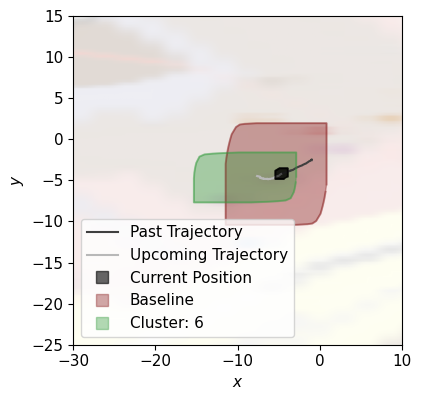

2024-08-07 16:02:31,568 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_964
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_964 ['0.png', 'reprocessed_2024-07-16-14-54-22.bag_964.csv']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:31,642 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.360097
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_964, {'c_8': 'Cluster: 8'}
Cluster: 8
Skipped Method: Cluster


2024-08-07 16:02:32,565 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_889
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_889 ['0.png', 'reprocessed_2024-07-16-14-54-22.bag_889.csv']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:32,644 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.875209
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_889, {'c_8': 'Cluster: 8'}
Cluster: 8
Skipped Method: Cluster


2024-08-07 16:02:33,522 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_889
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_889 ['0.png', 'reprocessed_2024-07-16-14-54-22.bag_889.csv']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:33,606 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.85636
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_889, {'c_8': 'Cluster: 8'}
Cluster: 8
Skipped Method: Cluster


2024-08-07 16:02:34,556 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_817
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_817 ['reprocessed_2024-07-16-14-54-22.bag_817.csv', '0.png']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:34,635 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.339116
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_817, {'c_8': 'Cluster: 8'}
Cluster: 8
X_p.size 686 (2, 343)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 84.54it/s]


X_p.size 1666 (2, 833)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:01<00:00, 31.28it/s]


Area of zonotope:  323.2875  m^2
Area of (baseline) zonotope:  73.9273  m^2


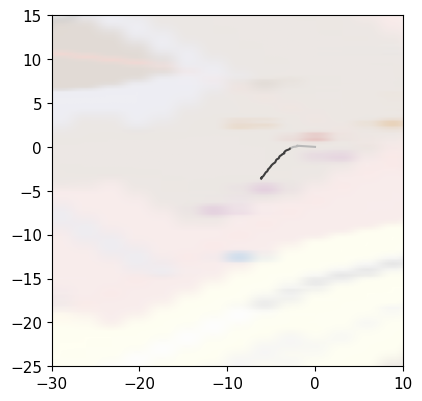

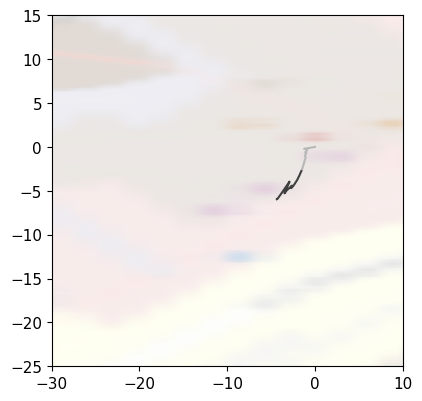

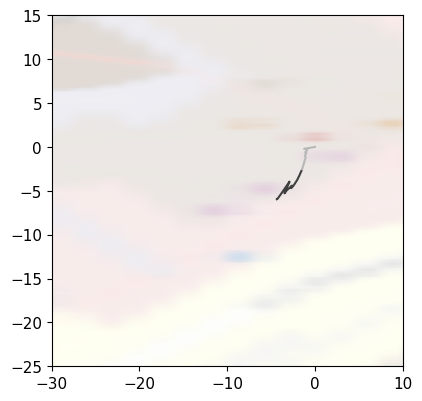

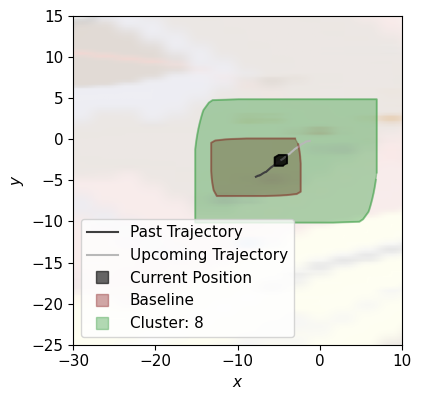

2024-08-07 16:02:38,762 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_908
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_908 ['reprocessed_2024-07-16-14-54-22.bag_908.csv', '0.png']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:38,842 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.850371
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_908, {'c_6': 'Cluster: 6'}
Cluster: 6
Skipped Method: Cluster


2024-08-07 16:02:39,753 | INFO : Loading 1 datasets files using 1 parallel processes ...


root_dir /home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_1015
/home/sam/Desktop/Pedestrian_Project/resources/test/reprocessed_2024-07-16-14-54-22.bag_1015 ['0.png', 'reprocessed_2024-07-16-14-54-22.bag_1015.csv']


/home/sam/Desktop/Pedestrian_Project/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-07 16:02:39,833 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear

Loaded model from /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/checkpoints/model_best.pth. Epoch: 156
Evaluating   0.0% | batch:         0 of         1	|	loss: 0.527271
Trajectory data shape need to be of shape  (n, m). Get 0 dimension as past trajectory
Load data from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters
Load Annoy Model from: /home/sam/Desktop/Pedestrian_Project/experiments/ROS_experiment_2024-08-02_10-47-55_tcO/eval/clusters/annoy_index.ann
Name: reprocessed_2024-07-16-14-54-22.bag_1015, {'c_8': 'Cluster: 8'}
Cluster: 8
X_p.size 392 (2, 196)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 131.69it/s]


X_p.size 196 (2, 98)
data_statistics {'baseline': {'memory_constraint': 0, 'data_constraint': 0}, 'total_count': 1, 'Cluster': {'memory_constraint': 0, 'data_constraint': 0}}


Calculating reachable sets: 100%|██████████| 48/48 [00:00<00:00, 275.71it/s]


Area of zonotope:  870.4588  m^2
Area of (baseline) zonotope:  1445.9995  m^2


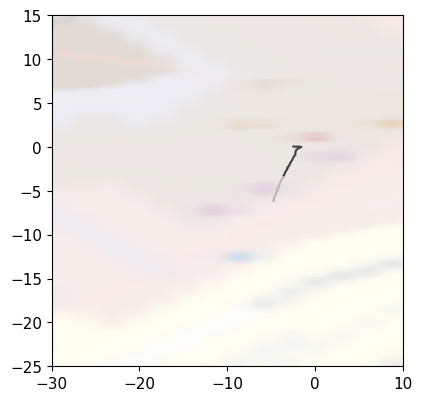

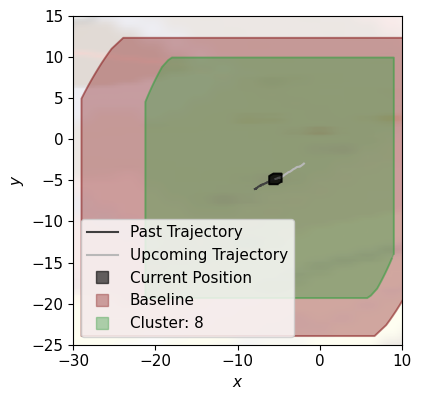

In [33]:
config['pattern'] = None
config['original_data'] = False

TEST_TRAJECTORIES = [
    'reprocessed_2024-07-16-14-54-22.bag_992',
    'reprocessed_2024-07-16-14-54-22.bag_964',
    'reprocessed_2024-07-16-14-54-22.bag_889',
    'reprocessed_2024-07-16-14-54-22.bag_889',
    'reprocessed_2024-07-16-14-54-22.bag_817',
    'reprocessed_2024-07-16-14-54-22.bag_908',
    'reprocessed_2024-07-16-14-54-22.bag_1015',
]

ROOT_RESOURCES = '/home/sam/Desktop/Pedestrian_Project/resources'

for name in TEST_TRAJECTORIES:
    config_test = config.copy()
    config_test['data_dir'] = ROOT_RESOURCES + f'/test/{name}'
    test_labeling_oracle = LabelingOracleROSData(config_test)
    test_labeling_oracle.load_data()

    trajectory, l = get_test_label(test_labeling_oracle)
    c, distance = get_cluster(config, test_labeling_oracle)
    test_cases = {f'c_{c}': f'Cluster: {c}'}

    print(f"Name: {name},", test_cases)
    print('Cluster:', c)
    run_scenario(trajectory=trajectory, config=config, labels=test_cases, show_plot=True, baseline=True, save_plot=config_test['data_dir'])

### Cluster picked for Zonotope

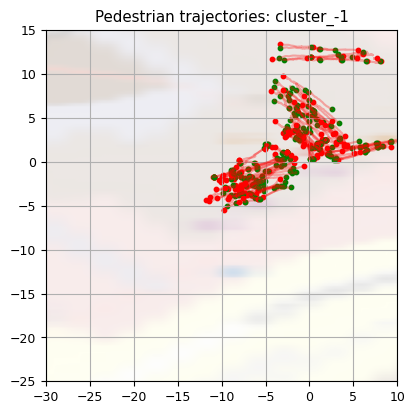

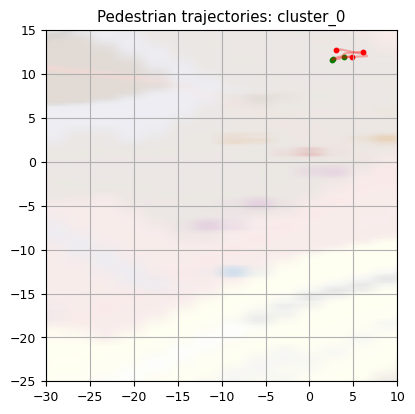

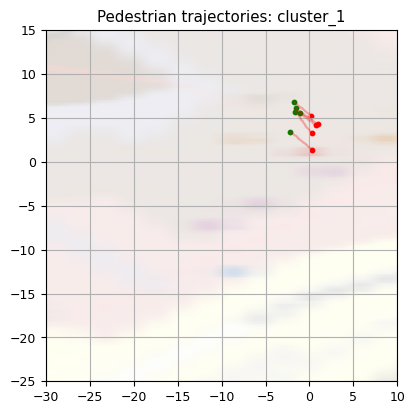

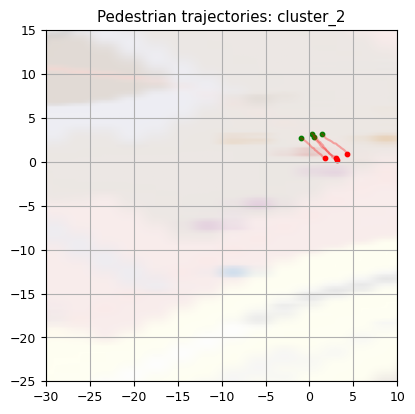

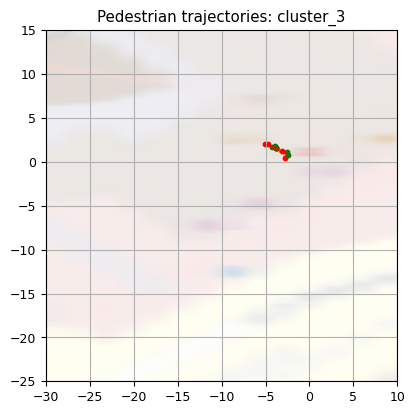

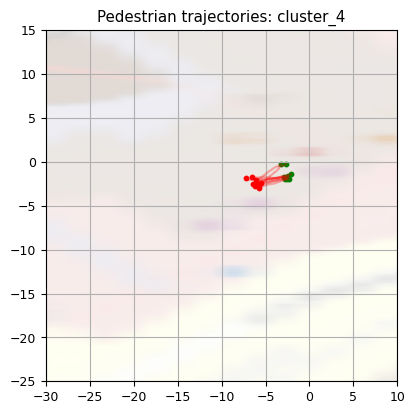

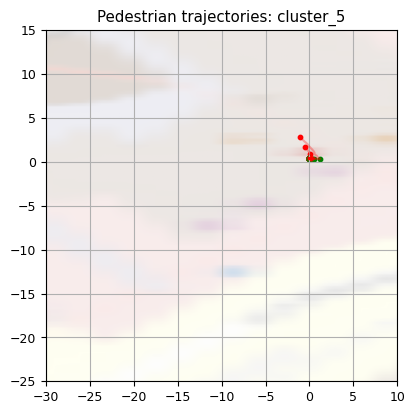

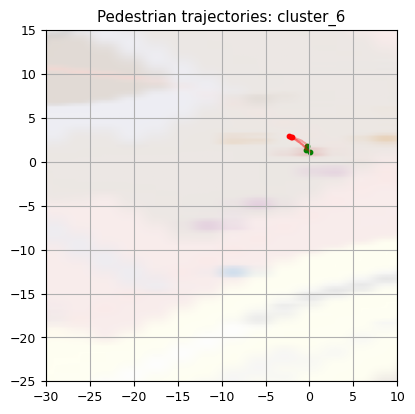

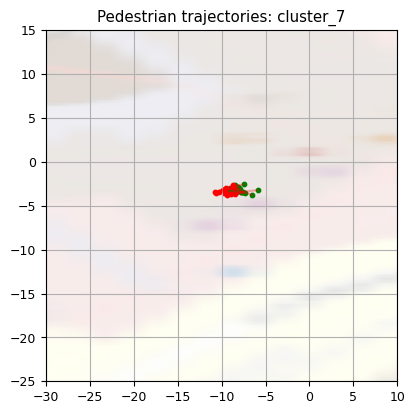

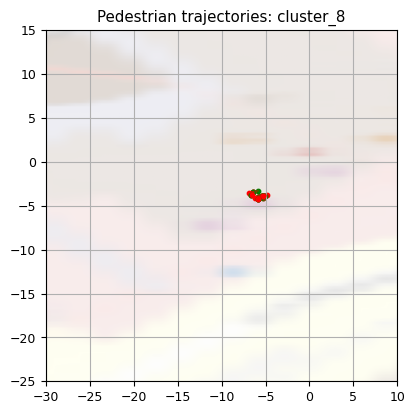

In [ ]:
for c in range(-1, 9):
    _sind_, d, _, mapping = get_data(_load=True, config=config, test_case=(c, 'Cluster'))
    _mode = mapping[c]
    _sind_.map.plot_dataset(pedestrian_data={i: data for i, data in enumerate(d[_mode])}, color='red', title=f'cluster_{c}', alpha_trajectories=0.3)